## Geospatial Analysis (HW2)

This assignment is for course EDS 296,  taught by Dr. Sam Stevenson.

Author: Naomi Moraes

GitHub: https://github.com/nmoraescommit/EDS296-HW2.git

### Import Libraries

In [1]:
# Import libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import intake

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


### Model Choice

I will be using the GFDL-ESM4 model developed by NOAA's Geophysical Fluid Dynamics Laboratory and the CanESM5 model from the Canadian Centre for Climate Modelling and Analysis, both of which participated in the Coupled Model Intercomparison Project Phase 6 (CMIP6). These models will be run under ssp126 which represents an optismitic climate scenario.

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

#Search through catalog and store results

# GFDL-ESM4 Historic
gfdl_esm4_hist = catalog.search(
    activity_id = 'CMIP',
    source_id = 'GFDL-ESM4',
    experiment_id = 'historical',
    member_id = 'r1i1p1f1',
    table_id = 'Amon',
    variable_id = 'tas'
)

# GFDL-ESM4 ssp126
gfdl_esm4_fut = catalog.search(
    activity_id = 'ScenarioMIP',
    source_id = 'GFDL-ESM4',
    experiment_id = 'ssp126',
    member_id = 'r1i1p1f1',
    table_id = 'Amon',
    variable_id = 'tas'
)

# CanESM5 Historic
CanESM5_hist = catalog.search(
    activity_id = 'CMIP',
    source_id = 'CanESM5',
    experiment_id = 'historical',
    member_id = 'r1i1p1f1',
    table_id = 'Amon',
    variable_id = 'tas'
)

# CanESM5 ssp126
CanESM5_fut = catalog.search(
    activity_id = 'ScenarioMIP',
    source_id = 'CanESM5',
    experiment_id = 'ssp126',
    member_id = 'r1i1p1f1',
    table_id = 'Amon',
    variable_id = 'tas'
)

In [3]:
# Look at the results
display(gfdl_esm4_hist.df)
display(gfdl_esm4_fut.df)
display(CanESM5_hist.df)
display(CanESM5_fut.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20190726


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp126,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CCCma,CanESM5,ssp126,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


In [4]:
# Grab results and save as xarray objects
GFDL_hist = xr.open_zarr(gfdl_esm4_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
GFDL_fut = xr.open_zarr(gfdl_esm4_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
Can_hist = xr.open_zarr(CanESM5_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
Can_fut = xr.open_zarr(CanESM5_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)

In [5]:
# Concatenate historical and future projections for both models
GFDL_data = xr.concat([GFDL_hist, GFDL_fut], dim="time")
Can_data = xr.concat([Can_hist, Can_fut], dim="time")

### Time Period and Area of Interest

I will be using the areas of Australia and New Zealand as my area of interest. Having lived in NZ, an island nation, I recognize the importance of planning for climate criss impacts like rising sea-levels. (As well as increasing temperatures - which will further devastate Australian peoples and biodiversity.) Furthermore, NZ might have been too small of an area, thus I broadened my geographic scope with the inclusion of Australia.

I am also interested in the historical period of 1925 to 1975 and a future period of 2025 to 2075. I selected the 'tas' vairable as I wanted to visualize the surface air temperature impacts on these countries, and if they trend differently in the future scenarios.

In [6]:
# Define min/max bounds for NZ
# [lon_min, lon_max, lat_min, lat_max]
region = [112, 180, -55, -9]

# Time periods of interest
per_early = [1975, 2025]
per_late = [2026, 2075]

In [7]:
# Fix datetime format
GFDL_data['time'] = GFDL_data.time.astype('datetime64[ns]')
Can_data['time'] = Can_data.time.astype('datetime64[ns]')

# Sort by time for filtering later on
GFDL_data = GFDL_data.sortby('time')
Can_data = Can_data.sortby('time')

In [8]:
# Slice the data to the time periods
# GFDL historical
GFDL_early = GFDL_data.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# GFDL future
GFDL_late = GFDL_data.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))
# GFDL historical
Can_early = Can_data.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# GFDL future
Can_late = Can_data.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

In [9]:
# Calculate the annual mean tas for each model and extract values

# GFDL historical
GFDL_early_mean = GFDL_early.mean(dim="time") - 273.15
GFDL_early_mean_tas = GFDL_early_mean.tas.values

# GFDL future
GFDL_late_mean = GFDL_late.mean(dim="time") - 273.15
GFDL_late_mean_tas = GFDL_late_mean.tas.values

In [10]:
# Can historical
Can_early_mean = Can_early.mean(dim="time") - 273.15
Can_early_mean_tas = Can_early_mean.tas.values

# Can future
Can_late_mean = Can_late.mean(dim="time") - 273.15
Can_late_mean_tas = Can_late_mean.tas.values

## Mapping

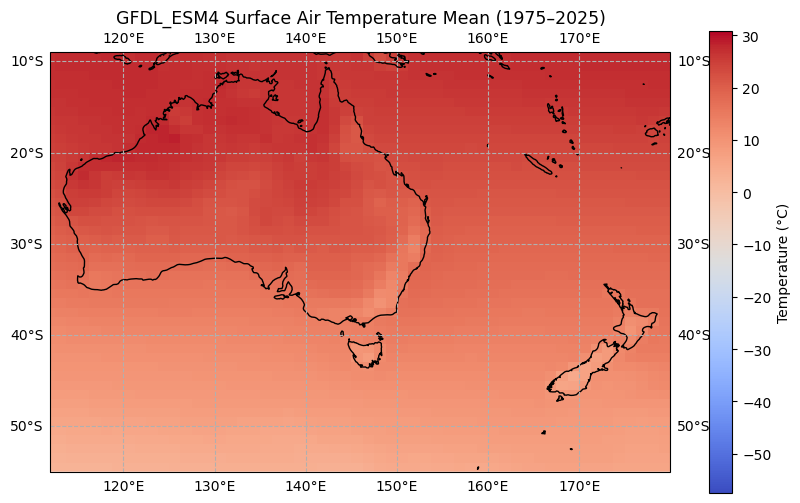

In [22]:
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize = (10, 6), 
                       subplot_kw = {"projection": proj})

plot = ax.pcolormesh(GFDL_early_mean.lon, 
                     GFDL_early_mean.lat, 
                     GFDL_early_mean_tas, 
                     transform = proj, 
                     cmap="coolwarm")

ax.set_extent(region, 
              crs = proj)

cbar = plt.colorbar(plot)
cbar.set_label("Temperature (°C)")

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, 
               linestyle=":")

gl = ax.gridlines(draw_labels=True, 
                  linestyle="--")

ax.set_title("GFDL_ESM4 Surface Air Temperature Mean (1975–2025)", 
             fontsize = 12.5)

plt.show()

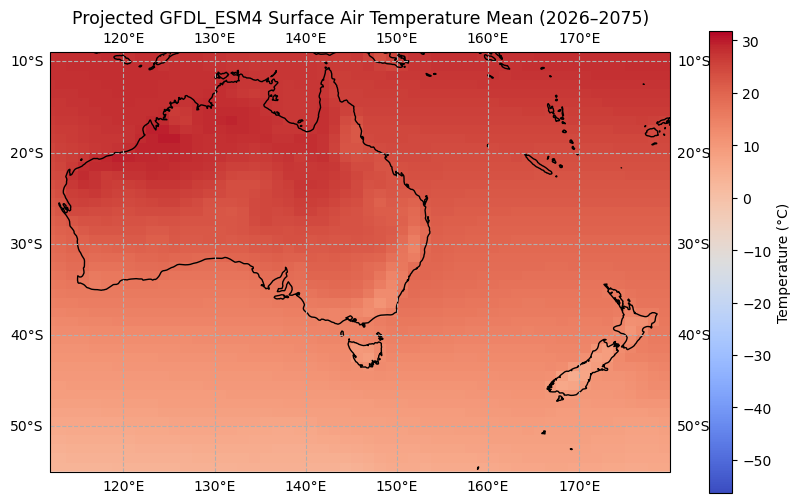

In [23]:
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize = (10, 6), 
                       subplot_kw = {"projection": proj})

plot = ax.pcolormesh(GFDL_late_mean.lon, 
                     GFDL_late_mean.lat, 
                     GFDL_late_mean_tas, 
                     transform = proj, 
                     cmap="coolwarm")

ax.set_extent(region, 
              crs = proj)

cbar = plt.colorbar(plot)
cbar.set_label("Temperature (°C)")

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, 
               linestyle=":")

gl = ax.gridlines(draw_labels=True, 
                  linestyle="--")

ax.set_title("Projected GFDL_ESM4 Surface Air Temperature Mean (2026–2075)", 
             fontsize = 12.5)

plt.show()

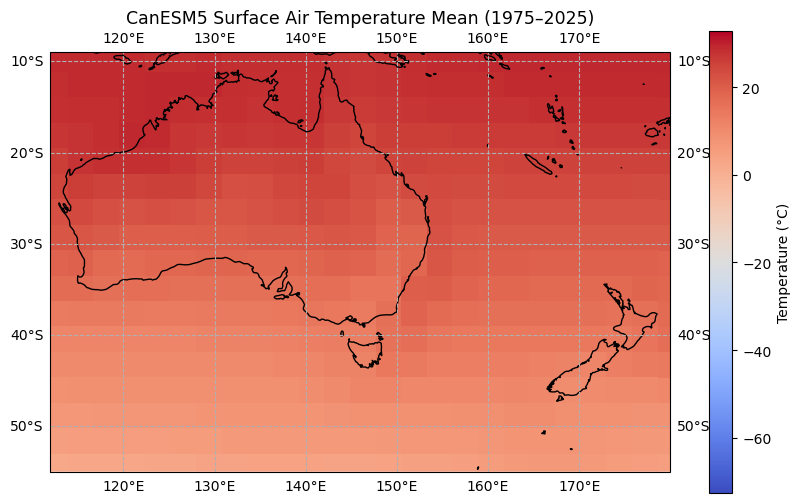

In [26]:
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize = (10, 6), 
                       subplot_kw = {"projection": proj})

plot = ax.pcolormesh(Can_early_mean.lon, 
                     Can_early_mean.lat, 
                     Can_early_mean_tas, 
                     transform = proj, 
                     cmap="coolwarm")

ax.set_extent(region, 
              crs = proj)

cbar = plt.colorbar(plot)
cbar.set_label("Temperature (°C)")

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, 
               linestyle=":")

gl = ax.gridlines(draw_labels=True, 
                  linestyle="--")

ax.set_title("CanESM5 Surface Air Temperature Mean (1975–2025)", 
             fontsize = 12.5)

plt.show()

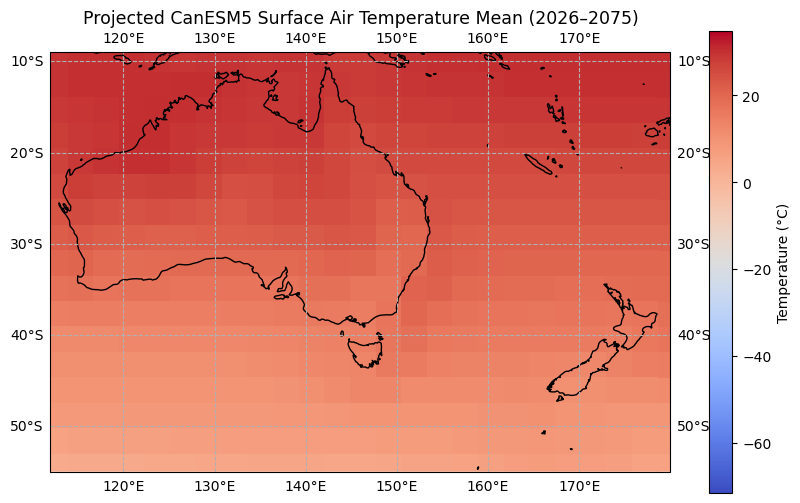

In [27]:
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize = (10, 6), 
                       subplot_kw = {"projection": proj})

plot = ax.pcolormesh(Can_late_mean.lon, 
                     Can_late_mean.lat, 
                     Can_late_mean_tas, 
                     transform = proj, 
                     cmap="coolwarm")

ax.set_extent(region, 
              crs = proj)

cbar = plt.colorbar(plot)
cbar.set_label("Temperature (°C)")

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, 
               linestyle=":")

gl = ax.gridlines(draw_labels=True, 
                  linestyle="--")

ax.set_title("Projected CanESM5 Surface Air Temperature Mean (2026–2075)", 
             fontsize = 12.5)

plt.show()

### Difference in Average Maps

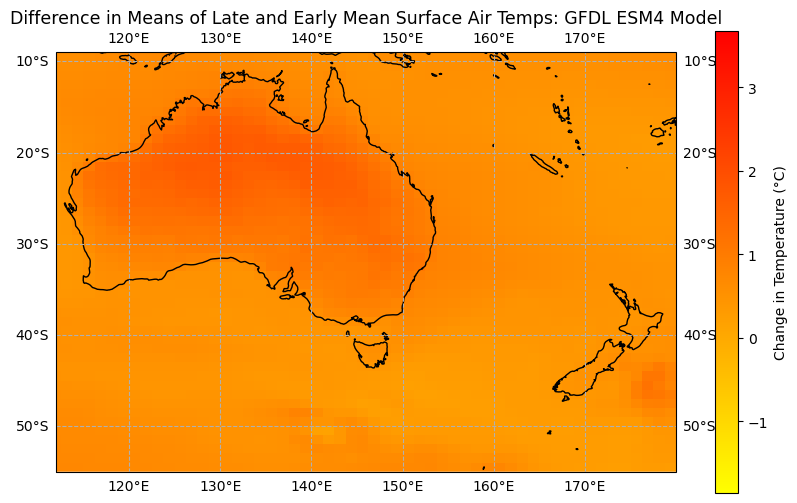

In [42]:
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize = (10, 6), 
                       subplot_kw={"projection": proj})

plot = ax.pcolormesh(GFDL_late_mean.lon, 
                     GFDL_late_mean.lat, 
                     (GFDL_late_mean_tas - GFDL_early_mean_tas), 
                     transform = proj, 
                     cmap = "autumn_r")

ax.set_extent(region, 
              crs=proj)

cbar = plt.colorbar(plot, 
                    ax = ax)
cbar.set_label("Change in Temperature (°C)")

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, 
               linestyle=":")

gl = ax.gridlines(draw_labels=True, 
                  linestyle="--")

ax.set_title("Difference in Means of Late and Early Mean Surface Air Temps: GFDL ESM4 Model", 
             fontsize = 12.5)

plt.show()

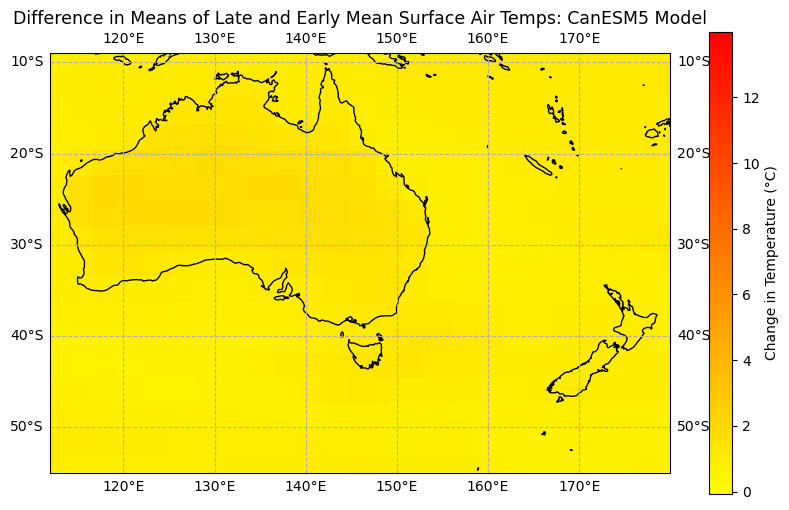

In [44]:
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize = (10, 6), 
                       subplot_kw={"projection": proj})

plot = ax.pcolormesh(Can_late_mean.lon, 
                     Can_late_mean.lat, 
                     (Can_late_mean_tas - Can_early_mean_tas), 
                     transform = proj, 
                     cmap = "autumn_r")

ax.set_extent(region, 
              crs=proj)

cbar = plt.colorbar(plot, 
                    ax = ax)
cbar.set_label("Change in Temperature (°C)")

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, 
               linestyle=":")

gl = ax.gridlines(draw_labels=True, 
                  linestyle="--")

ax.set_title("Difference in Means of Late and Early Mean Surface Air Temps: CanESM5 Model", 
             fontsize = 12.5)

plt.show()

### Final Thoughts

When looking at the initial four plots, of surface air temperature, for the  tasmanian region - the look visually similar - for both the  GFDL-ESM amd the CanESM5 models (for both the past and future periods.) However, contrasted with the difference in mean plots, we can observe that the GFDL-ESM shows that temperature in that area generally rises (especially in inland Australia) while the CanESM5 maps shows generally no change (while still echoing that inland increase.) Taking into account that the SSP126, is quite a optimistic scenario, I believe that the rising temperatures in this area is more likely than no change, impacting people (heat stroke, drought) as well as fauna and flora, negatively.